# Basic understanding of the data

Quite a lot of useful information is available here: https://www.kaggle.com/code/gmudit/tsa-wind-power-forecasting

Key insights:
* We have 5 wind farms.
* For each, we have the data about the wind power generation.
* In parallel, we have some predictions that are available with some prediction horizons.
* For the Kaggle competition, we have a train and test file.
* It might be useful to see what is actually being predicted - how long is the prediction horizon.

Let's see for which horizons the competition was.'

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
df_forecasts = pd.read_csv("GEF2012-wind-forecasting/windforecasts_wf1.csv")
df_train = pd.read_csv("GEF2012-wind-forecasting/train.csv")
df_test = pd.read_csv("GEF2012-wind-forecasting/test.csv")


def parse_date(date_string_series):
    return pd.to_datetime(date_string_series, format="%Y%m%d%H")


df_train["date"] = parse_date(df_train["date"])
df_test["date"] = parse_date(df_test["date"])
df_train_dates = df_train.loc[:, ["date"]]
df_test_dates = df_test.loc[:, ["date"]]
df_train_dates["value"] = 2
df_test_dates["value"] = 1
df_dates_both = pd.concat([df_train_dates, df_test_dates], ignore_index=True)
df_dates_both.sort_values("date", inplace=True)

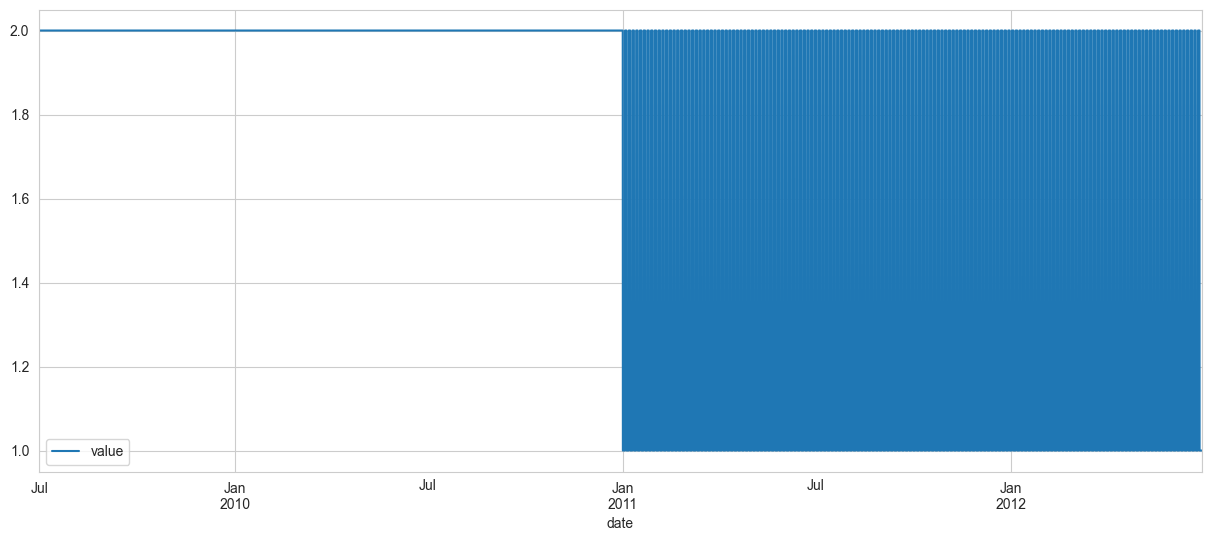

In [27]:
plt.rcParams["figure.figsize"] = (15, 6)
df_dates_both.plot("date", "value");

So we can see that in the first half, the data are there for training. In the second half, we can observe some oscillations. Let's zoom in.

<Axes: xlabel='date'>

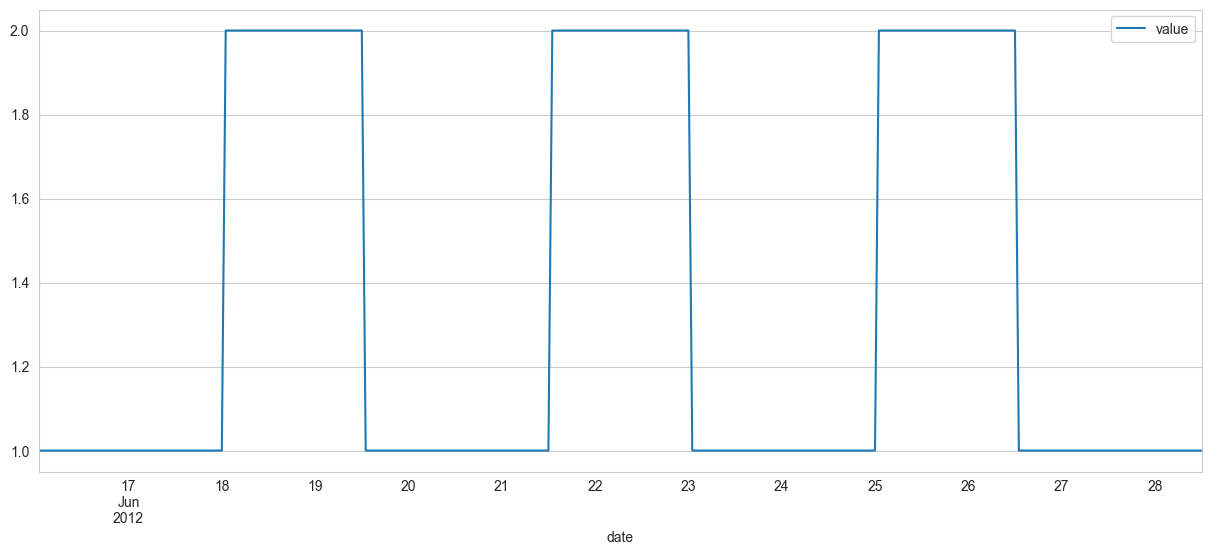

In [28]:
df_dates_both[-300:].plot("date", "value")

Manual inspection into the data:

In [29]:
df_dates_both[-300:]

,date,value
19150,2012-06-16 01:00:00,1
20253,2012-06-16 02:00:00,1
23630,2012-06-16 03:00:00,1
23820,2012-06-16 04:00:00,1
19160,2012-06-16 05:00:00,1
...,...,...
22543,2012-06-28 08:00:00,1
21840,2012-06-28 09:00:00,1
20223,2012-06-28 10:00:00,1
24945,2012-06-28 11:00:00,1


Let's see when the train vs. test switch - timestamp before the switch and after that.

In [49]:
def get_interesting_dates(df):
    mask = (df['value'].shift(1) == df['value']) & (df['value'].shift(-1) == df['value'])
    return df[~mask].copy()


df_interesting_dates = get_interesting_dates(
    df_dates_both
)
df_interesting_dates

,date,value
0,2009-07-01 00:00:00,2
13176,2011-01-01 00:00:00,2
24788,2011-01-01 01:00:00,1
24436,2011-01-03 00:00:00,1
13177,2011-01-03 01:00:00,2
...,...,...
20285,2012-06-25 00:00:00,1
18721,2012-06-25 01:00:00,2
18756,2012-06-26 12:00:00,2
24424,2012-06-26 13:00:00,1


Where the pure training ends:

In [58]:
when_pure_training_ends = df_interesting_dates.iloc[1,:]["date"]
when_pure_training_ends

Timestamp('2011-01-01 00:00:00')

48 hours to be predicted, 36 provided. Data is a bit weird, simply for the sake of the given competition.

Anyway, the data set indicates that it is reasonable to use it for the short term forecasts (such as one day).


# Use Case Introduction

## Task definition:
* We are on an island (say in Indonesia).
* We have a wind turbine.
* We have two diesel generators.
* We have some demand.
* We want to minimize the fuel consumption.

## Disclaimer:
The goal is to demonstrate end-to-end practically oriented application of the machine learning, including a tangible outcome. For this purpose, some simplifications have been adopted:
* We work with one wind farm only.
* We work only with forecasts that are related to that wind farm. In practice, data from other wind farms might be beneficial, too.
* The machine learning does not examine all possible approaches that might be appropriate if we would try to solve the Kaggle challenge.
* The optimization algorithm uses linear demand curves.
* The full dynamic programming may face problems when more units in the microgrid. Approximate dynamic programming or reinforcement learning might be more appropriate.

## Components:
* Wind generation forecast
* Demand forecast
* Efficiency curves of diesel generators
* Cost model: 1) fuel needed for operation of a diesel generator, 2) fuel needed for running the diesel generator
* Dynamic programming

## Evaluation
* Optimize the the switch
* To compare with a naive approach: run both diesel generators just in case

# Demand

Load hypothetical data of a demand in an island with 1000 inhabitants. ChatGPT was used to obtain these parameters so they are possibly realistic.

In [35]:
df_daily_demand = pd.read_json("demand_example.json")
df_daily_demand

,Hour,Percentage of Peak Demand,Notes
0,0,50,"Midnight - low activity, some street lights, s..."
1,1,48,Decreasing activity as it gets later.
2,2,46,"Minimal activity, mostly just essential services."
3,3,45,Steady low demand; perhaps some early risers.
4,4,45,"Still low, but some might start waking up towa..."
5,5,50,Early morning activities start; some shops mig...
6,6,60,Increased residential demand as households wak...
7,7,70,"Morning peak starts; households are active, an..."
8,8,80,Continued morning activities; schools and work...
9,9,85,Near-peak demand as all commercial activities ...


Estimating the power consumption for an island with a population of 1000 people can vary widely based on a myriad of factors including the standard of living, types of establishments present, industrial activities, and more. However, I can provide a rough estimation based on some assumptions.

1. **Residential Consumption**:
   - Assume each household consists of 4 people, so there are 250 households.
   - Assume each household has a daily consumption ranging from 5 kWh to 10 kWh (this is a modest estimate, accounting for lighting, appliances, cooking, and some air conditioning or heating).
   - Total residential consumption = 250 households × 5 to 10 kWh = 1,250 to 2,500 kWh daily.

2. **Commercial and Public Services**:
   - Assume there are services like shops, restaurants, schools, and maybe a small clinic or health center.
   - Estimating an average daily consumption of 20 kWh for each establishment and assuming there are 50 such establishments: 50 × 20 kWh = 1,000 kWh daily.

3. **Street Lighting**:
   - Assume there are 200 street lights.
   - If each street light uses a 100W LED bulb and runs for 10 hours, then: 200 lights × 0.1 kW × 10 hours = 200 kWh daily.

4. **Other Miscellaneous Uses**:
   - This could include water pumping, communications infrastructure, any small-scale industries, or tourism-related activities (like hotels or attractions). It's hard to estimate without specifics, but let's allocate an additional 500 to 1,000 kWh for these purposes.

**Total Estimated Consumption**:
   - Summing up all the above: 1,250 + 1,000 + 200 + 500 = 2,950 kWh to 2,500 + 1,000 + 200 + 1,000 = 4,700 kWh daily.

**Daily Maximum and Minimum**:
   - Minimum: 2,950 kWh
   - Maximum: 4,700 kWh

Peak demand (which is the maximum power demand at any instance) will be lower than the total daily maximum, as not all consumption occurs simultaneously. Similarly, during off-peak hours (like late night), the power demand will be much lower.

These numbers are ballpark estimates and can vary widely based on the actual conditions, behaviors, and needs of the island's inhabitants. For a more accurate assessment, detailed surveys and studies would be required.

In [42]:
max_peak_demand = 4_700
demand_curve = df_daily_demand["Percentage of Peak Demand"] / 100 * max_peak_demand

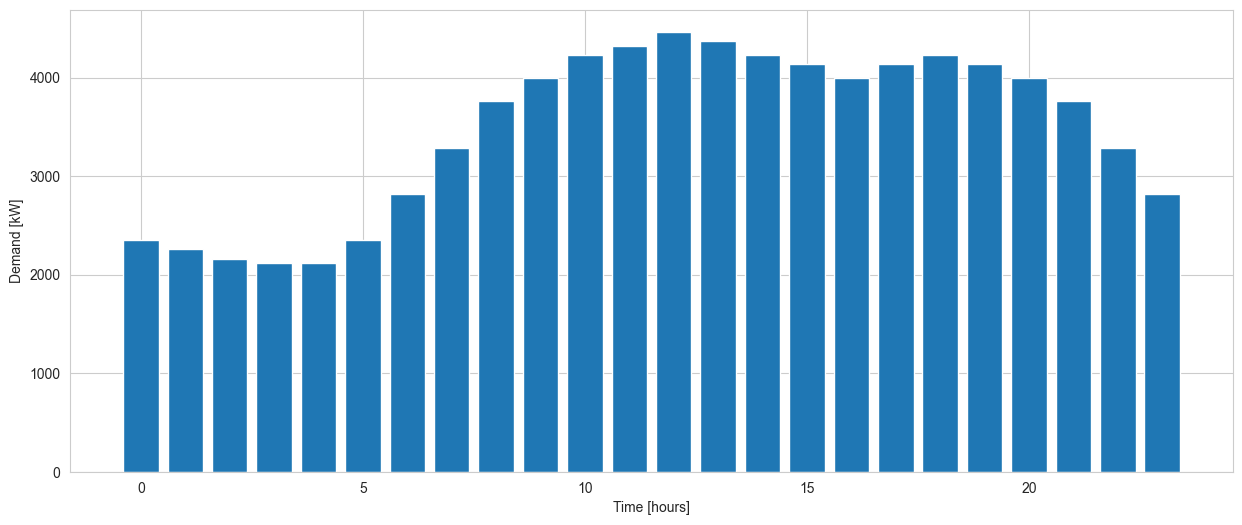

In [43]:
plt.bar(range(len(demand_curve)), demand_curve)
plt.xlabel("Time [hours]")
plt.ylabel("Demand [kW]");

# Wind Farm Power Generation - Machine Learning
In this section, we will examine the potential of machine learning to forecast the wind farm power generation.


## Selecting the data from the original dataset
For the simplicity sake, we will ensure the modelling from midnight to midnight and we will select also the range accordingly - the original data contained quite some gaps.

In [68]:
df_wind_generation = pd.read_csv("GEF2012-wind-forecasting/train.csv")

In [69]:
df_wind_generation.sort_values("date", inplace=True)

In [70]:
df_wind_generation["date"] = parse_date(df_wind_generation["date"])
df_wind_generation

,date,wp1,wp2,wp3,wp4,wp5,wp6,wp7
0,2009-07-01 00:00:00,0.045,0.233,0.494,0.105,0.056,0.118,0.051
1,2009-07-01 01:00:00,0.085,0.249,0.257,0.105,0.066,0.066,0.051
2,2009-07-01 02:00:00,0.020,0.175,0.178,0.033,0.015,0.026,0.000
3,2009-07-01 03:00:00,0.060,0.085,0.109,0.022,0.010,0.013,0.000
4,2009-07-01 04:00:00,0.045,0.032,0.079,0.039,0.010,0.000,0.000
...,...,...,...,...,...,...,...,...
18752,2012-06-26 08:00:00,0.170,0.138,0.119,0.149,0.339,0.132,0.101
18753,2012-06-26 09:00:00,0.211,0.106,0.208,0.193,0.359,0.132,0.076
18754,2012-06-26 10:00:00,0.251,0.090,0.247,0.132,0.329,0.132,0.076
18755,2012-06-26 11:00:00,0.301,0.058,0.356,0.061,0.293,0.105,0.076


Working with purely "training" data in the original dataset to ensure the midnight-to-midnight forecast.

In [77]:
df_wind_generation.sort_values("date", inplace=True)

In [86]:
# manually tuned from when_pure_training_ends to start at midnight
where_we_start=9648


In [87]:
horizon = 24
df_my_day = df_wind_generation[["wp1", "date"]].iloc[where_we_start:(where_we_start + horizon)]
df_my_day

,wp1,date
9648,0.366,2010-08-07 00:00:00
9649,0.195,2010-08-07 01:00:00
9650,0.130,2010-08-07 02:00:00
9651,0.135,2010-08-07 03:00:00
9652,0.201,2010-08-07 04:00:00
9653,0.180,2010-08-07 05:00:00
9654,0.115,2010-08-07 06:00:00
9655,0.105,2010-08-07 07:00:00
9656,0.070,2010-08-07 08:00:00
9657,0.120,2010-08-07 09:00:00


## Preprocessing the Weather Forecasts

From the data before `where_we_start`, we want to create a model and predict this particular data. Let's check what forecasts do we have for this!

In [88]:
df_forecasts

,date,hors,u,v,ws,wd,hors_delta,forecast_date
0,2009-07-01 00:00:00,1,2.34,-0.79,2.47,108.68,0 days 01:00:00,2009-07-01 01:00:00
1,2009-07-01 00:00:00,2,2.18,-0.99,2.40,114.31,0 days 02:00:00,2009-07-01 02:00:00
2,2009-07-01 00:00:00,3,2.20,-1.21,2.51,118.71,0 days 03:00:00,2009-07-01 03:00:00
3,2009-07-01 00:00:00,4,2.35,-1.40,2.73,120.86,0 days 04:00:00,2009-07-01 04:00:00
4,2009-07-01 00:00:00,5,2.53,-1.47,2.93,120.13,0 days 05:00:00,2009-07-01 05:00:00
...,...,...,...,...,...,...,...,...
104827,2012-06-26 12:00:00,44,2.44,1.08,2.67,66.14,1 days 20:00:00,2012-06-28 08:00:00
104828,2012-06-26 12:00:00,45,2.11,1.46,2.57,55.39,1 days 21:00:00,2012-06-28 09:00:00
104829,2012-06-26 12:00:00,46,1.63,1.61,2.29,45.42,1 days 22:00:00,2012-06-28 10:00:00
104830,2012-06-26 12:00:00,47,1.07,1.58,1.91,34.05,1 days 23:00:00,2012-06-28 11:00:00


In [89]:
df_forecasts["date"] = parse_date(df_forecasts["date"])
df_forecasts['hors_delta'] = pd.to_timedelta(df_forecasts.hors, unit='hours')
df_forecasts['forecast_date'] = df_forecasts['date'] + df_forecasts['hors_delta']

In [90]:
df_forecasts

,date,hors,u,v,ws,wd,hors_delta,forecast_date
0,2009-07-01 00:00:00,1,2.34,-0.79,2.47,108.68,0 days 01:00:00,2009-07-01 01:00:00
1,2009-07-01 00:00:00,2,2.18,-0.99,2.40,114.31,0 days 02:00:00,2009-07-01 02:00:00
2,2009-07-01 00:00:00,3,2.20,-1.21,2.51,118.71,0 days 03:00:00,2009-07-01 03:00:00
3,2009-07-01 00:00:00,4,2.35,-1.40,2.73,120.86,0 days 04:00:00,2009-07-01 04:00:00
4,2009-07-01 00:00:00,5,2.53,-1.47,2.93,120.13,0 days 05:00:00,2009-07-01 05:00:00
...,...,...,...,...,...,...,...,...
104827,2012-06-26 12:00:00,44,2.44,1.08,2.67,66.14,1 days 20:00:00,2012-06-28 08:00:00
104828,2012-06-26 12:00:00,45,2.11,1.46,2.57,55.39,1 days 21:00:00,2012-06-28 09:00:00
104829,2012-06-26 12:00:00,46,1.63,1.61,2.29,45.42,1 days 22:00:00,2012-06-28 10:00:00
104830,2012-06-26 12:00:00,47,1.07,1.58,1.91,34.05,1 days 23:00:00,2012-06-28 11:00:00


<Axes: xlabel='date'>

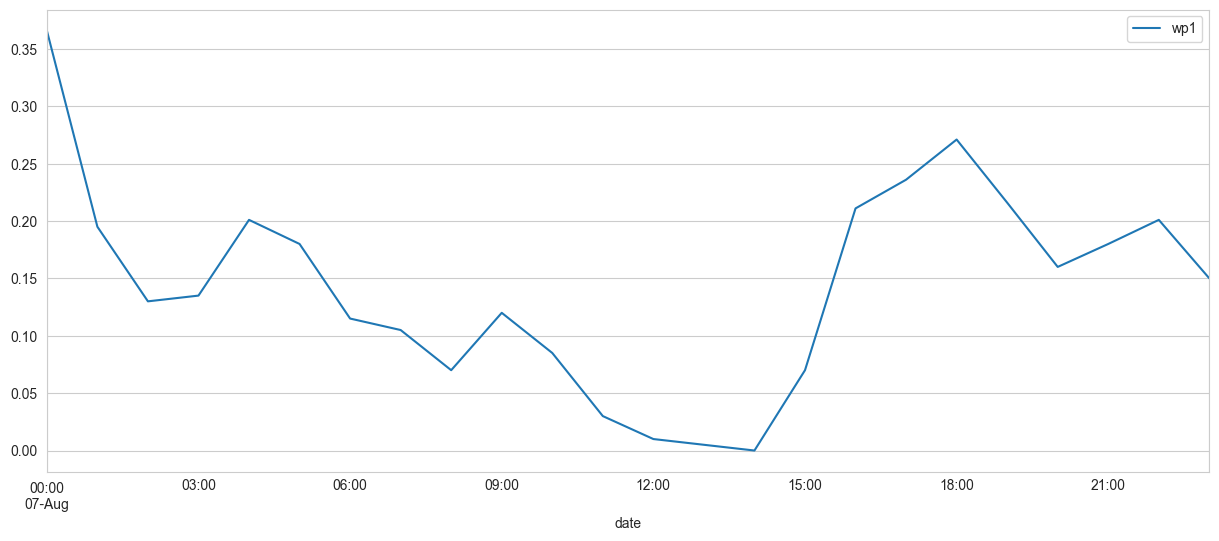

In [91]:
df_my_day.plot("date", "wp1")

In [92]:
min_date = df_my_day["date"].min()
max_date = df_my_day["date"].max()
min_date, max_date

(Timestamp('2010-08-07 00:00:00'), Timestamp('2010-08-07 23:00:00'))

Let's see how the forecasts for the my_day look like. We can see that there are multiple for each point of time:

In [93]:
mask = (df_forecasts["forecast_date"] >= min_date) & (df_forecasts["forecast_date"] < max_date)
df_relevant_forecasts = df_forecasts[mask]
df_relevant_forecasts

,date,hors,u,v,ws,wd,hors_delta,forecast_date
38447,2010-08-05 00:00:00,48,2.31,-2.88,3.70,141.24,2 days 00:00:00,2010-08-07 00:00:00
38483,2010-08-05 12:00:00,36,1.89,-1.89,2.67,135.10,1 days 12:00:00,2010-08-07 00:00:00
38484,2010-08-05 12:00:00,37,1.67,-1.40,2.18,129.97,1 days 13:00:00,2010-08-07 01:00:00
38485,2010-08-05 12:00:00,38,2.11,-1.14,2.40,118.39,1 days 14:00:00,2010-08-07 02:00:00
38486,2010-08-05 12:00:00,39,2.66,-0.99,2.84,110.38,1 days 15:00:00,2010-08-07 03:00:00
...,...,...,...,...,...,...,...,...
38645,2010-08-07 12:00:00,6,6.32,-1.74,6.56,105.39,0 days 06:00:00,2010-08-07 18:00:00
38646,2010-08-07 12:00:00,7,6.12,-1.20,6.23,101.06,0 days 07:00:00,2010-08-07 19:00:00
38647,2010-08-07 12:00:00,8,5.41,-0.41,5.42,94.37,0 days 08:00:00,2010-08-07 20:00:00
38648,2010-08-07 12:00:00,9,4.41,0.33,4.42,85.67,0 days 09:00:00,2010-08-07 21:00:00


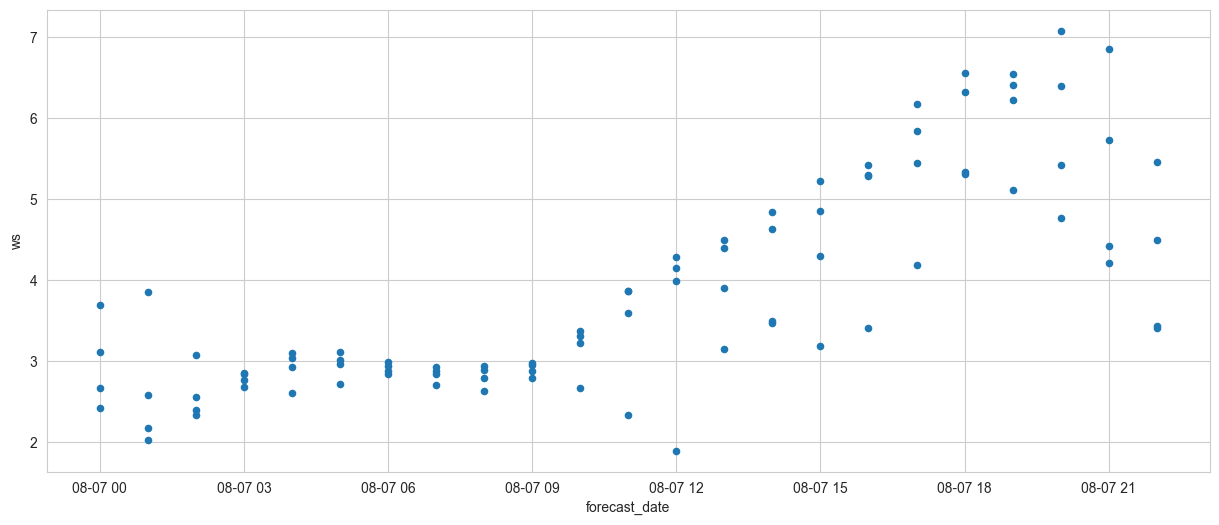

In [95]:
df_relevant_forecasts.plot("forecast_date", "ws", kind="scatter");

## Forecast Aggregation and Data Chunking

For the sake of simplicity, let's work with the average *forecast* only. There might be more sophisticated ways of doing it.

During the preprocessing, we have to avoid *data leakage*. This will be ensured by
 focusing on the midnight-to-midnight forecast only. This will guarantee that the training data are fully separated from the testing data.

Later, we can work with some sequences of days (e.g. weeks) that we will consider to be either test or train dataset, and we can generate more data by shifting by hour to hour.



In [98]:
df_available_forecasts = df_forecasts[df_forecasts.forecast_date < min_date].sort_values("forecast_date")
df_available_forecasts.tail()
df_available_forecasts

,date,hors,u,v,ws,wd,hors_delta,forecast_date
0,2009-07-01 00:00:00,1,2.34,-0.79,2.47,108.68,0 days 01:00:00,2009-07-01 01:00:00
1,2009-07-01 00:00:00,2,2.18,-0.99,2.40,114.31,0 days 02:00:00,2009-07-01 02:00:00
2,2009-07-01 00:00:00,3,2.20,-1.21,2.51,118.71,0 days 03:00:00,2009-07-01 03:00:00
3,2009-07-01 00:00:00,4,2.35,-1.40,2.73,120.86,0 days 04:00:00,2009-07-01 04:00:00
4,2009-07-01 00:00:00,5,2.53,-1.47,2.93,120.13,0 days 05:00:00,2009-07-01 05:00:00
...,...,...,...,...,...,...,...,...
38481,2010-08-05 12:00:00,34,4.76,-3.41,5.85,125.60,1 days 10:00:00,2010-08-06 22:00:00
38482,2010-08-05 12:00:00,35,3.08,-2.65,4.06,130.74,1 days 11:00:00,2010-08-06 23:00:00
38446,2010-08-05 00:00:00,47,3.42,-3.77,5.09,137.83,1 days 23:00:00,2010-08-06 23:00:00
38518,2010-08-06 00:00:00,23,2.92,-2.37,3.76,129.06,0 days 23:00:00,2010-08-06 23:00:00


In [99]:
df_relevant_forecasts

,date,hors,u,v,ws,wd,hors_delta,forecast_date
38447,2010-08-05 00:00:00,48,2.31,-2.88,3.70,141.24,2 days 00:00:00,2010-08-07 00:00:00
38483,2010-08-05 12:00:00,36,1.89,-1.89,2.67,135.10,1 days 12:00:00,2010-08-07 00:00:00
38484,2010-08-05 12:00:00,37,1.67,-1.40,2.18,129.97,1 days 13:00:00,2010-08-07 01:00:00
38485,2010-08-05 12:00:00,38,2.11,-1.14,2.40,118.39,1 days 14:00:00,2010-08-07 02:00:00
38486,2010-08-05 12:00:00,39,2.66,-0.99,2.84,110.38,1 days 15:00:00,2010-08-07 03:00:00
...,...,...,...,...,...,...,...,...
38645,2010-08-07 12:00:00,6,6.32,-1.74,6.56,105.39,0 days 06:00:00,2010-08-07 18:00:00
38646,2010-08-07 12:00:00,7,6.12,-1.20,6.23,101.06,0 days 07:00:00,2010-08-07 19:00:00
38647,2010-08-07 12:00:00,8,5.41,-0.41,5.42,94.37,0 days 08:00:00,2010-08-07 20:00:00
38648,2010-08-07 12:00:00,9,4.41,0.33,4.42,85.67,0 days 09:00:00,2010-08-07 21:00:00


In [98]:
def pivot_column(df, col_name):
    """Pivot the DataFrame based on forecast_hour for a given column."""
    pivot_df = df.pivot_table(index='forecast_just_date', columns='forecast_hour', values=col_name, aggfunc="mean")
    pivot_df.columns = [f'{col_name}{col}' for col in pivot_df.columns]
    return pivot_df


def pivot_multiple_columns(df):
    columns_to_pivot = ["u", "v", "ws", "wd"]
    df["forecast_hour"] = df["forecast_date"].dt.hour
    df["forecast_just_date"] = df["forecast_date"].dt.date

    pivoted_dfs = [pivot_column(df, col) for col in columns_to_pivot]

    # Concatenate results
    result = pd.concat(pivoted_dfs, axis=1).sort_index(axis=1)
    return result


df_pivoted_forecast = pivot_multiple_columns(df_available_forecasts)
df_pivoted_forecast

,u0,u1,u10,u11,u12,u13,u14,u15,u16,u17,...,ws21,ws22,ws23,ws3,ws4,ws5,ws6,ws7,ws8,ws9
forecast_just_date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,NaN,2.340000,3.2300,3.6500,3.890000,3.2950,3.3300,3.2750,3.2100,3.1300,...,2.3250,2.0500,1.7700,2.5100,2.730000,2.930000,2.9600,2.810000,2.730000,2.870000
2009-07-02,0.8250,0.403333,-0.0900,-0.5600,-0.826667,-0.4100,0.0150,0.4625,0.8350,1.1725,...,3.8700,3.8075,3.4950,1.4600,1.223333,0.956667,0.8400,0.823333,0.923333,1.086667
2009-07-03,2.1250,2.080000,4.0025,4.6000,5.027500,4.5950,4.5900,4.7325,5.0925,5.5700,...,7.2575,7.1250,6.8350,2.5850,2.700000,2.892500,3.0650,3.157500,3.277500,3.575000
2009-07-04,5.6800,5.082500,3.0550,3.8200,4.582500,5.1100,5.2450,5.1475,4.9000,4.6500,...,6.2550,5.1600,3.7575,4.2650,3.902500,3.690000,3.4575,3.120000,2.877500,3.015000
2009-07-05,2.3175,2.652500,3.5050,3.5150,3.527500,3.5350,3.6325,3.6700,3.6750,3.7150,...,4.5400,3.8250,2.9100,3.3375,3.507500,3.535000,3.5125,3.495000,3.487500,3.490000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-22,3.8200,3.507500,2.9950,3.4525,3.755000,3.3600,3.1200,2.9400,2.9475,3.0925,...,3.2750,2.5475,1.6700,3.2350,3.320000,3.472500,3.5075,3.307500,3.057500,3.007500
2010-07-23,0.5625,0.632500,-3.0375,-2.8000,-2.065000,1.2800,2.9250,4.5000,5.6975,6.4725,...,5.7275,4.6450,3.4775,2.0350,2.190000,2.595000,3.3750,4.365000,5.292500,5.867500
2010-07-24,2.5050,2.577500,3.0600,3.5725,4.067500,4.9750,5.2825,5.3150,5.1375,4.7800,...,3.3200,3.5425,3.9200,2.2825,2.292500,2.345000,2.4075,2.440000,2.517500,2.740000


In [99]:
pivot_multiple_columns((df_relevant_forecasts))

C:\Users\kajam\AppData\Local\Temp\ipykernel_40872\2152503218.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["forecast_hour"] = df["forecast_date"].dt.hour
C:\Users\kajam\AppData\Local\Temp\ipykernel_40872\2152503218.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["forecast_just_date"] = df["forecast_date"].dt.date


,u0,u1,u10,u11,u12,u13,u14,u15,u16,u17,...,ws20,ws21,ws22,ws3,ws4,ws5,ws6,ws7,ws8,ws9
forecast_just_date,,,,,,,,,,,,,,,,,,,,,
2010-07-27,1.75,2.1025,3.18,3.245,3.12,2.7125,2.3275,2.125,2.21,2.4775,...,3.1625,3.005,2.63,2.98,3.1325,3.105,3.025,2.9875,3.015,3.09


Okay, now we need the previous observed generation.

In [100]:
df_wind1 = df_wind_generation[["wp1", "date"]].copy()

In [101]:
df_wind1["just_date"] = df_wind1["date"].dt.date
df_wind1["hour"] = df_wind1["date"].dt.hour

In [102]:
df_wind1

,wp1,date,just_date,hour
0,0.045,2009-07-01 00:00:00,2009-07-01,0
1,0.085,2009-07-01 01:00:00,2009-07-01,1
2,0.020,2009-07-01 02:00:00,2009-07-01,2
3,0.060,2009-07-01 03:00:00,2009-07-01,3
4,0.045,2009-07-01 04:00:00,2009-07-01,4
...,...,...,...,...
18752,0.170,2012-06-26 08:00:00,2012-06-26,8
18753,0.211,2012-06-26 09:00:00,2012-06-26,9
18754,0.251,2012-06-26 10:00:00,2012-06-26,10
18755,0.301,2012-06-26 11:00:00,2012-06-26,11


In [103]:
df_power_per_day = df_wind1.pivot_table(index="just_date", columns="hour", values="wp1")

X = previous day + forecast
y = current day

In [104]:
df_power_per_day

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
just_date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,0.045,0.085,0.020,0.060,0.045,0.035,0.005,0.000,0.000,0.010,...,0.010,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.015
2009-07-02,0.000,0.000,0.010,0.010,0.000,0.000,0.000,0.000,0.000,0.015,...,0.000,0.000,0.010,0.010,0.010,0.010,0.010,0.080,0.025,0.080
2009-07-03,0.201,0.120,0.035,0.050,0.080,0.065,0.140,0.080,0.055,0.025,...,0.095,0.095,0.190,0.221,0.226,0.301,0.421,0.486,0.476,0.476
2009-07-04,0.521,0.476,0.501,0.662,0.747,0.622,0.406,0.190,0.110,0.075,...,0.461,0.451,0.376,0.266,0.241,0.236,0.226,0.271,0.271,0.296
2009-07-05,0.190,0.120,0.195,0.281,0.221,0.140,0.216,0.281,0.206,0.185,...,0.010,0.000,0.010,0.035,0.030,0.020,0.045,0.070,0.085,0.065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.040,0.321,0.080
2012-06-22,0.145,0.065,0.055,0.105,0.135,0.115,0.080,0.095,0.120,0.115,...,0.085,0.105,0.120,0.165,0.201,0.241,0.261,0.326,0.291,0.296
2012-06-23,0.281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_power_per_day["tomorrow"] = df_power_per_day.index + pd.Timedelta(days=1)

1. Value of no information
2. Value of perfect information
3. Value of the model

Note that the optimization evolves over time.


In [106]:
df_power_per_day

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,tomorrow
just_date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,0.045,0.085,0.020,0.060,0.045,0.035,0.005,0.000,0.000,0.010,...,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.015,2009-07-02
2009-07-02,0.000,0.000,0.010,0.010,0.000,0.000,0.000,0.000,0.000,0.015,...,0.000,0.010,0.010,0.010,0.010,0.010,0.080,0.025,0.080,2009-07-03
2009-07-03,0.201,0.120,0.035,0.050,0.080,0.065,0.140,0.080,0.055,0.025,...,0.095,0.190,0.221,0.226,0.301,0.421,0.486,0.476,0.476,2009-07-04
2009-07-04,0.521,0.476,0.501,0.662,0.747,0.622,0.406,0.190,0.110,0.075,...,0.451,0.376,0.266,0.241,0.236,0.226,0.271,0.271,0.296,2009-07-05
2009-07-05,0.190,0.120,0.195,0.281,0.221,0.140,0.216,0.281,0.206,0.185,...,0.000,0.010,0.035,0.030,0.020,0.045,0.070,0.085,0.065,2009-07-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.040,0.321,0.080,2012-06-22
2012-06-22,0.145,0.065,0.055,0.105,0.135,0.115,0.080,0.095,0.120,0.115,...,0.105,0.120,0.165,0.201,0.241,0.261,0.326,0.291,0.296,2012-06-23
2012-06-23,0.281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-06-24


In [107]:
#history
df_available_forecasts.shape

(37460, 10)

In [108]:
# for the current day
df_relevant_forecasts.shape

(92, 10)

In [109]:
X = df_power_per_day.merge(df_pivoted_forecast, left_on="tomorrow", right_index=True)

In [110]:
y = df_power_per_day.drop("tomorrow", axis=1).copy()
y

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
just_date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,0.045,0.085,0.020,0.060,0.045,0.035,0.005,0.000,0.000,0.010,...,0.010,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.005,0.015
2009-07-02,0.000,0.000,0.010,0.010,0.000,0.000,0.000,0.000,0.000,0.015,...,0.000,0.000,0.010,0.010,0.010,0.010,0.010,0.080,0.025,0.080
2009-07-03,0.201,0.120,0.035,0.050,0.080,0.065,0.140,0.080,0.055,0.025,...,0.095,0.095,0.190,0.221,0.226,0.301,0.421,0.486,0.476,0.476
2009-07-04,0.521,0.476,0.501,0.662,0.747,0.622,0.406,0.190,0.110,0.075,...,0.461,0.451,0.376,0.266,0.241,0.236,0.226,0.271,0.271,0.296
2009-07-05,0.190,0.120,0.195,0.281,0.221,0.140,0.216,0.281,0.206,0.185,...,0.010,0.000,0.010,0.035,0.030,0.020,0.045,0.070,0.085,0.065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.040,0.321,0.080
2012-06-22,0.145,0.065,0.055,0.105,0.135,0.115,0.080,0.095,0.120,0.115,...,0.085,0.105,0.120,0.165,0.201,0.241,0.261,0.326,0.291,0.296
2012-06-23,0.281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
y.shape

(937, 24)

In [112]:
X.set_index("tomorrow", inplace=True)

In [113]:
X

,0,1,2,3,4,5,6,7,8,9,...,ws21,ws22,ws23,ws3,ws4,ws5,ws6,ws7,ws8,ws9
tomorrow,,,,,,,,,,,,,,,,,,,,,
2009-07-02,0.045,0.085,0.020,0.060,0.045,0.035,0.005,0.000,0.000,0.010,...,3.8700,3.8075,3.4950,1.4600,1.223333,0.956667,0.8400,0.823333,0.923333,1.086667
2009-07-03,0.000,0.000,0.010,0.010,0.000,0.000,0.000,0.000,0.000,0.015,...,7.2575,7.1250,6.8350,2.5850,2.700000,2.892500,3.0650,3.157500,3.277500,3.575000
2009-07-04,0.201,0.120,0.035,0.050,0.080,0.065,0.140,0.080,0.055,0.025,...,6.2550,5.1600,3.7575,4.2650,3.902500,3.690000,3.4575,3.120000,2.877500,3.015000
2009-07-05,0.521,0.476,0.501,0.662,0.747,0.622,0.406,0.190,0.110,0.075,...,4.5400,3.8250,2.9100,3.3375,3.507500,3.535000,3.5125,3.495000,3.487500,3.490000
2009-07-06,0.190,0.120,0.195,0.281,0.221,0.140,0.216,0.281,0.206,0.185,...,6.3150,5.7550,5.1500,2.3875,2.265000,2.502500,2.6500,2.675000,2.790000,2.905000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-22,0.015,0.045,0.040,0.115,0.090,0.060,0.015,0.015,0.040,0.105,...,3.2750,2.5475,1.6700,3.2350,3.320000,3.472500,3.5075,3.307500,3.057500,3.007500
2010-07-23,0.286,0.180,0.125,0.150,0.160,0.211,0.256,0.266,0.221,0.201,...,5.7275,4.6450,3.4775,2.0350,2.190000,2.595000,3.3750,4.365000,5.292500,5.867500
2010-07-24,0.015,0.005,0.115,0.095,0.070,0.075,0.236,0.246,0.291,0.105,...,3.3200,3.5425,3.9200,2.2825,2.292500,2.345000,2.4075,2.440000,2.517500,2.740000


In [114]:
y = y.loc[X.index]

In [115]:
y

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
tomorrow,,,,,,,,,,,,,,,,,,,,,
2009-07-02,0.000,0.000,0.010,0.010,0.000,0.000,0.000,0.000,0.000,0.015,...,0.000,0.000,0.010,0.010,0.010,0.010,0.010,0.080,0.025,0.080
2009-07-03,0.201,0.120,0.035,0.050,0.080,0.065,0.140,0.080,0.055,0.025,...,0.095,0.095,0.190,0.221,0.226,0.301,0.421,0.486,0.476,0.476
2009-07-04,0.521,0.476,0.501,0.662,0.747,0.622,0.406,0.190,0.110,0.075,...,0.461,0.451,0.376,0.266,0.241,0.236,0.226,0.271,0.271,0.296
2009-07-05,0.190,0.120,0.195,0.281,0.221,0.140,0.216,0.281,0.206,0.185,...,0.010,0.000,0.010,0.035,0.030,0.020,0.045,0.070,0.085,0.065
2009-07-06,0.015,0.010,0.035,0.090,0.115,0.060,0.050,0.030,0.000,0.000,...,0.085,0.055,0.085,0.211,0.266,0.185,0.160,0.075,0.175,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-22,0.286,0.180,0.125,0.150,0.160,0.211,0.256,0.266,0.221,0.201,...,0.085,0.095,0.050,0.100,0.090,0.080,0.110,0.045,0.110,0.040
2010-07-23,0.015,0.005,0.115,0.095,0.070,0.075,0.236,0.246,0.291,0.105,...,0.100,0.155,0.386,0.461,0.667,0.712,0.622,0.376,0.376,0.381
2010-07-24,0.296,0.246,0.105,0.155,0.095,0.090,0.065,0.060,0.070,0.075,...,0.236,0.286,0.160,0.030,0.000,0.005,0.005,0.095,0.045,0.005


In [116]:
y.shape

(390, 24)

## Training the model

In [117]:
from sklearn.model_selection import train_test_split

In [118]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split the temporary set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.22222, random_state=42)

In [119]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,ws21,ws22,ws23,ws3,ws4,ws5,ws6,ws7,ws8,ws9
tomorrow,,,,,,,,,,,,,,,,,,,,,
2009-11-12,0.236,0.271,0.326,0.331,0.316,0.296,0.206,0.185,0.216,0.170,...,1.7875,2.1850,2.8925,3.7825,3.7850,3.6700,3.5075,3.3900,3.2800,3.1375
2010-03-02,0.266,0.241,0.226,0.201,0.221,0.306,0.346,0.236,0.266,0.356,...,1.7050,2.0025,2.3225,2.9650,3.2450,3.4625,3.4775,3.2025,2.8125,2.5400
2009-11-13,0.075,0.130,0.216,0.361,0.441,0.391,0.381,0.256,0.251,0.185,...,2.7600,2.7075,2.9450,3.5775,3.4825,3.4325,3.4325,3.4625,3.4700,3.3775
2009-09-07,0.050,0.040,0.030,0.015,0.000,0.000,0.000,0.000,0.000,0.010,...,2.2450,2.3100,2.3250,2.7325,2.7950,2.7600,2.6175,2.3950,2.1525,1.9625
2010-01-01,0.256,0.351,0.336,0.411,0.331,0.376,0.406,0.416,0.361,0.291,...,5.4900,5.6100,5.6900,2.2925,2.3575,2.4250,2.4475,2.4075,2.3750,2.4275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-09-19,0.015,0.020,0.140,0.070,0.095,0.195,0.376,0.351,0.536,0.541,...,0.6000,1.1700,1.8200,3.0200,3.1875,3.2850,3.2300,2.9725,2.6275,2.3425
2009-12-16,0.015,0.005,0.000,0.000,0.015,0.010,0.005,0.045,0.055,0.030,...,3.8425,3.5000,3.7025,4.1450,4.0800,4.1100,4.1500,4.1300,4.0750,4.0200
2010-06-03,0.090,0.020,0.100,0.095,0.201,0.201,0.306,0.406,0.321,0.271,...,2.1725,2.2400,2.1800,3.7350,3.5425,3.6375,3.7400,3.8350,3.8625,3.7775


In [120]:
X_train.shape

(273, 120)

In [121]:
y_train.shape

(273, 24)

In [122]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


In [123]:
XX = X_train.values  # Sample data
yy = y_train.values  # Sample multi-label binary data


In [124]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(120,)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(24, activation='sigmoid')  # 24 outputs, and sigmoid ensures values are between 0 and 1
])



In [125]:
model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=(120,)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(24, activation='sigmoid')  # 24 outputs, and sigmoid ensures values are between 0 and 1
])

In [126]:
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Using Mean Squared Error for regression problems
              metrics=['mae'])  # Mean Absolute Error as a metric for regression


In [127]:
model.fit(XX, yy, epochs=1000, batch_size=8, validation_split=0.1)


Epoch 1/1000
31/31 [==============================] - 1s 7ms/step - loss: 0.1804 - mae: 0.3464 - val_loss: 0.1171 - val_mae: 0.3084
Epoch 2/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.1210 - mae: 0.3141 - val_loss: 0.1098 - val_mae: 0.3000
Epoch 3/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.1103 - mae: 0.3002 - val_loss: 0.1013 - val_mae: 0.2872
Epoch 4/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.0957 - mae: 0.2735 - val_loss: 0.0927 - val_mae: 0.2739
Epoch 5/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.0825 - mae: 0.2488 - val_loss: 0.0833 - val_mae: 0.2583
Epoch 6/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.0774 - mae: 0.2412 - val_loss: 0.0753 - val_mae: 0.2420
Epoch 7/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.0718 - mae: 0.2303 - val_loss: 0.0701 - val_mae: 0.2308
Epoch 8/1000
31/31 [==============================] - 0s 3ms/step - loss: 0.

In [128]:
model.predict(X_test.values) - y_test.values

2/2 [==============================] - 0s 3ms/step


array([[ 4.51762559e-02,  9.54962089e-02, -2.28748057e-02,
        -3.01338313e-02, -7.77105353e-02, -1.45675146e-01,
        -1.16811718e-01, -1.29582146e-01, -1.56010974e-01,
        -1.91470815e-01, -1.10583778e-01,  6.25004640e-02,
         1.26465735e-01,  9.37020888e-02,  1.54458083e-01,
         3.01859138e-01,  2.71747271e-01,  9.97091177e-02,
        -5.15700719e-02, -1.61216035e-01, -2.05654109e-01,
        -1.50552546e-01, -1.60744006e-01, -2.38830235e-01],
       [ 1.16681820e-01,  1.18709351e-01,  1.04713660e-01,
         1.12336618e-01,  1.38591052e-01,  1.54564574e-01,
         1.47607535e-01,  1.41425014e-01,  1.27531916e-01,
         1.24361391e-01,  1.20068535e-01,  1.14898995e-01,
         1.04908563e-01,  9.12740901e-02,  8.00322220e-02,
         7.16107786e-02,  7.30072260e-02,  7.51297101e-02,
         6.91035092e-02,  7.06461444e-02,  7.13153854e-02,
         8.00342411e-02,  8.38467702e-02,  8.42144421e-02],
       [-3.40823744e-01, -3.90503791e-01, -3.63874806e

In [129]:
from sklearn.metrics import mean_absolute_error

y_val_pred = model.predict(X_val.values)
mean_absolute_error(y_val_pred, y_val.values)

3/3 [==============================] - 0s 2ms/step


0.1610621073504862

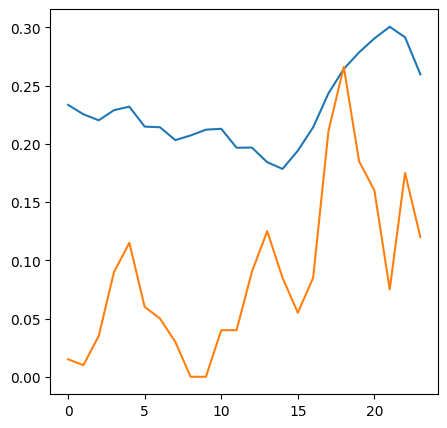

In [130]:
import matplotlib.pyplot as plt

plt.plot(y_val_pred[20, :])
plt.plot(y_val.iloc[20, :])


In [131]:
X_val.iloc[0, :]

0      0.3010
1      0.4810
2      0.6020
3      0.6820
4      0.7420
        ...  
ws5    3.7600
ws6    3.7525
ws7    3.7300
ws8    3.6625
ws9    3.5425
Name: 2010-04-02, Length: 120, dtype: float64

In [132]:
y.max()

hour
0     0.942
1     0.947
2     0.947
3     0.947
4     0.947
5     0.917
6     0.882
7     0.907
8     0.922
9     0.922
10    0.917
11    0.917
12    0.882
13    0.902
14    0.907
15    0.932
16    0.937
17    0.917
18    0.927
19    0.942
20    0.942
21    0.947
22    0.932
23    0.932
dtype: float64

## Optimizing the Hyperparameters

In [100]:
import optuna
from concurrent.futures import ThreadPoolExecutor
from functools import partial


def create_and_fit_model(num_layers=3, dropout_rate=0.1, num_neurons=64, batch_sizes=32):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(120,)))

    for i in range(num_layers):
        model.add(layers.Dense(num_neurons, activation='relu'))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(24, activation='sigmoid'))

    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    history = model.fit(XX, yy, epochs=1000, batch_size=batch_sizes, validation_split=0.1, verbose=0)
    return (history, model)


def just_the_score(num_layers, dropout_rate, num_neurons, batch_sizes, i):
    history, _ = create_and_fit_model(num_layers, dropout_rate, num_neurons, batch_sizes)
    return history.history['val_loss'][-1]


def objective(trial):
    # Define hyperparameter space using trial object
    num_layers = trial.suggest_int('num_layers', 2, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    num_neurons = trial.suggest_categorical('num_neurons', [8, 16, 32, 64, 128])
    batch_sizes = trial.suggest_categorical('batch_sizes', [8, 16, 32, 64])
    my_function = partial(just_the_score, num_layers, dropout_rate, num_neurons, batch_sizes)
    n_iter = 20
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(my_function, range(n_iter)))

    return sum(results) / n_iter


study_name = 'example-study-absolute3'
storage_name = 'sqlite:///example.db'
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
# study.optimize(objective, n_trials=10)

[I 2023-09-26 01:04:20,569] Using an existing study with name 'example-study-absolute3' instead of creating a new one.


In [134]:
study.best_params

{'num_layers': 5, 'dropout_rate': 0.1, 'num_neurons': 64, 'batch_sizes': 32}

In [135]:
history, model = create_and_fit_model(**study.best_params)

In [136]:
range(study.best_params["num_layers"])

range(0, 5)

In [137]:
model

In [138]:
history.history['val_loss'][-1]

0.12980642914772034

In [139]:
mean_absolute_error(y_test, model.predict(X_test.values))


2/2 [==============================] - 0s 0s/step


0.14103075656877312

## Benchmark Model 1: Average of the Last Demand

In [140]:
def dummy_predict_average(X_tmp):
    averages = X_tmp.iloc[:, :24].mean(axis=1)
    print(averages.shape)
    return pd.concat([averages] * 24, axis=1, keys=range(24))

In [141]:
y_test_pred = dummy_predict_average(X_test)

(39,)


In [142]:
y_test_pred

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
tomorrow,,,,,,,,,,,,,,,,,,,,,
2009-07-11,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875,...,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875,0.164875
2009-08-13,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208,...,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208,0.050208
2009-08-04,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042,...,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042,0.364042
2010-05-09,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042,...,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042,0.680042
2010-03-31,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792,...,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792,0.071792
2010-07-14,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458,...,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458,0.016458
2009-08-26,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375,...,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375,0.288375
2010-03-27,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708,...,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708,0.251708
2010-03-04,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208,...,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208,0.119208


In [143]:
mean_absolute_error(y_test, y_test_pred)

0.1734412393162393

## Last Generation

In [144]:
def dummy_predict_previous(X_tmp):
    return X_tmp.iloc[:, :24]

In [145]:
mean_absolute_error(y_test, dummy_predict_previous(X_test))

0.20083440170940173

# Microgrid Optimization

In [146]:
import itertools


def generate_binary_tuples(D):
    return [item for item in itertools.product([0, 1], repeat=D)]


D = 2
a_all = generate_binary_tuples(D)

In [147]:
y_test_pred = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step


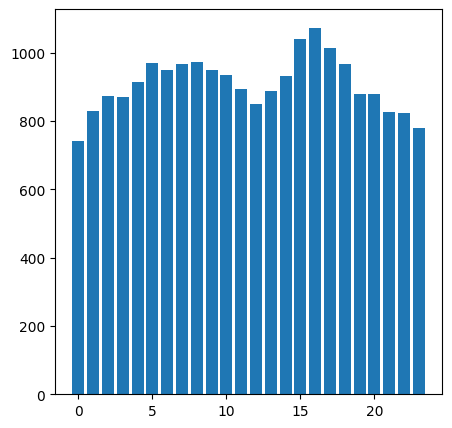

In [148]:
max_windfarm_output = 2_000
wind_farm_output_forecast = max_windfarm_output * y_test_pred[0, :]
plt.bar(range(len(wind_farm_output_forecast)), wind_farm_output_forecast);

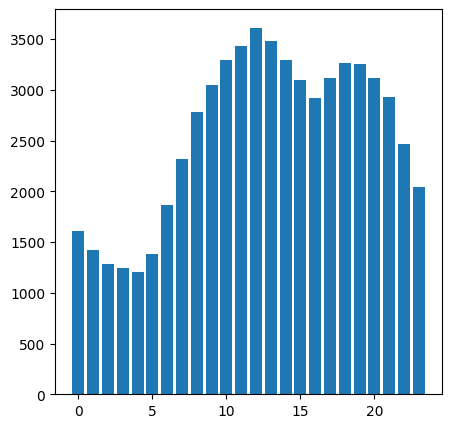

In [149]:
remaining_demand_forecast = demand_curve - wind_farm_output_forecast
plt.bar(range(24), remaining_demand_forecast);

In [150]:
df_generators = pd.DataFrame(
    {
        "min_output": [300.0, 200.0],
        "max_output": [3000.0, 2000.0],
        "fuel_liter_per_kW_output": [0.24, 0.27],
        "startup_fuel_consumption_liters": [120.0, 75.0]
    }
)
df_generators

,min_output,max_output,fuel_liter_per_kW_output,startup_fuel_consumption_liters
0,300.0,3000.0,0.24,120.0
1,200.0,2000.0,0.27,75.0


In [151]:
a_t = (0, 1)


def non_zero_indices(t):
    return [i for i, value in enumerate(t) if value != 0]


df_generators.iloc[non_zero_indices(a_t), :]

,min_output,max_output,fuel_liter_per_kW_output,startup_fuel_consumption_liters
1,200.0,2000.0,0.27,75.0


In [183]:
penalty_insufficient_generation = 24 * 5000 * 0.27 * 10
penalty_excessive_generation = 24 * 5000 * 0.27 * 1  # reliability 10x more important than excessive generation
df_generators.sort_values("fuel_liter_per_kW_output",
                          inplace=True)  # to start with the most optimal generators that are turned on


def optimal_one_step(remaining_load, a_t):
    df_active_generators = df_generators.iloc[non_zero_indices(a_t), :]
    min_output, max_output = df_active_generators[["min_output", "max_output"]].sum().to_list()
    if remaining_load > max_output:
        return penalty_insufficient_generation, ...
    elif remaining_load < min_output:
        return penalty_excessive_generation, ...
    else:

        outputs = df_active_generators.loc[:, "min_output"].copy()
        remaining_load -= np.sum(outputs)
        for i, row in df_active_generators.iterrows():
            if remaining_load < 0.000001:
                break
            load_by_ith_generator = np.min([remaining_load, row["max_output"] - row["min_output"]])
            remaining_load -= load_by_ith_generator

            new_value = outputs.loc[i] + load_by_ith_generator
            outputs.loc[i] = new_value

        fuel_consumption = (df_active_generators["fuel_liter_per_kW_output"] * outputs).sum()
        return fuel_consumption, outputs


optimal_one_step(2086.033203125, (1, 0))
optimal_one_step(2000, (0, 1))

(540.0,
 1    2000.0
 Name: min_output, dtype: float64)

In [153]:
V = pd.DataFrame(index=a_all, columns=(range(24 + 1)))
A = pd.DataFrame(index=a_all, columns=(range(24 + 1)))

In [154]:
V.iloc[:, -1] = 0
V

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
"(0, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
"(0, 1)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
"(1, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
"(1, 1)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [155]:
def get_switch_cost(a_t, a_t_1):
    indices_of_switch_on = [i for i, (x, y) in enumerate(zip(a_t, a_t_1)) if x == 0 and y == 1]

    if len(indices_of_switch_on) == 0:
        return 0
    else:
        return df_generators.iloc[indices_of_switch_on, :]["startup_fuel_consumption_liters"].sum()

In [156]:
switch_cost = pd.DataFrame(index=a_all, columns=a_all)
for a_t in a_all:
    for a_t_1 in a_all:
        switch_cost.at[a_t, a_t_1] = get_switch_cost(a_t, a_t_1)
switch_cost

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
"(0, 0)",0,75.0,120.0,195.0
"(0, 1)",0,0,120.0,120.0
"(1, 0)",0,75.0,0,75.0
"(1, 1)",0,0,0,0


In [157]:
switch_cost.at[(0, 0), (1, 1)]

195.0

In [158]:
next_series = pd.Series({
    "a": 2,
    "b": 1,
    "c": 1
})
min_index = next_series.argmin()
next_series.index[min_index]

'b'

In [184]:
T = 23


def get_next_tmp(a_t, t):
    next_series = pd.Series({a_t_1: switch_cost.at[a_t, a_t_1] + V.at[a_t_1, t + 1] for a_t_1 in a_all})
    print(next_series)
    min_index = next_series.argmin()
    arg_min_a = next_series.index[min_index]
    next_tmp = next_series.at[arg_min_a]
    return next_tmp, arg_min_a


dispatch = {t: {} for t in range(T + 1)}

for t in range(T, -1, -1):
    print(t)
    for a_t in a_all:
        print(a_t)
        print(remaining_demand_forecast[t])
        r_tmp, outputs = optimal_one_step(remaining_demand_forecast[t], a_t)
        dispatch[t][a_t] = outputs
        next_tmp, arg_min_a = get_next_tmp(a_t, t)
        print(r_tmp, next_tmp)
        V.at[a_t, t] = r_tmp + next_tmp
        A.at[a_t, t] = arg_min_a
    print(t)

23
(0, 0)
2040.7334594726562
0  0      0.0
   1     75.0
1  0    120.0
   1    195.0
dtype: float64
324000.00000000006 0.0
(0, 1)
2040.7334594726562
0  0      0.0
   1      0.0
1  0    120.0
   1    120.0
dtype: float64
324000.00000000006 0.0
(1, 0)
2040.7334594726562
0  0     0.0
   1    75.0
1  0     0.0
   1    75.0
dtype: float64
489.77603027343747 0.0
(1, 1)
2040.7334594726562
0  0    0
   1    0
1  0    0
   1    0
dtype: int64
495.77603027343747 0
23
22
(0, 0)
2467.34228515625
0  0    324000.00000
   1    324075.00000
1  0       609.77603
   1       690.77603
dtype: float64
324000.00000000006 609.7760302734375
(0, 1)
2467.34228515625
0  0    324000.00000
   1    324000.00000
1  0       609.77603
   1       615.77603
dtype: float64
324000.00000000006 609.7760302734375
(1, 0)
2467.34228515625
0  0    324000.00000
   1    324075.00000
1  0       489.77603
   1       570.77603
dtype: float64
592.1621484374999 489.77603027343747
(1, 1)
2467.34228515625
0  0    324000.00000
   1    32

In [185]:
dispatch

{0: {(0, 0): Ellipsis,
  (0, 1): 1    1607.127563
  Name: min_output, dtype: float64,
  (1,
   0): 0    1607.127563
  Name: min_output, dtype: float64,
  (1,
   1): 0    1407.127563
  1     200.000000
  Name: min_output, dtype: float64},
 1: {(0, 0): Ellipsis,
  (0, 1): 1    1426.694397
  Name: min_output, dtype: float64,
  (1,
   0): 0    1426.694397
  Name: min_output, dtype: float64,
  (1,
   1): 0    1226.694397
  1     200.000000
  Name: min_output, dtype: float64},
 2: {(0, 0): Ellipsis,
  (0, 1): 1    1288.89679
  Name: min_output, dtype: float64,
  (1,
   0): 0    1288.89679
  Name: min_output, dtype: float64,
  (1,
   1): 0    1088.89679
  1     200.00000
  Name: min_output, dtype: float64},
 3: {(0, 0): Ellipsis,
  (0, 1): 1    1243.918335
  Name: min_output, dtype: float64,
  (1,
   0): 0    1243.918335
  Name: min_output, dtype: float64,
  (1,
   1): 0    1043.918335
  1     200.000000
  Name: min_output, dtype: float64},
 4: {(0, 0): Ellipsis,
  (0, 1): 1    1200.889038
  

In [166]:
V

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
"(0, 0)",338681.522349,338339.115694,338029.780464,337731.240064,337443.026695,337111.535235,336662.832222,336105.228272,335436.150855,334699.286402,...,329771.012953,329069.870209,328314.685043,327523.728964,326734.57355,325905.720615,325201.938179,324609.77603,324000.0,0
"(0, 1)",15088.446791,14691.323181,14338.782598,14022.098015,13716.266735,13427.463127,13104.623112,336036.228272,335361.150855,334624.286402,...,329702.012953,328994.870209,328239.685043,327448.728964,326659.57355,325905.720615,325201.938179,324609.77603,324000.0,0
"(1, 0)",14947.232964,14561.522349,14219.115694,13909.780464,13611.240064,13323.026695,12991.535235,12542.832222,11985.228272,334579.286402,...,329651.012953,5651.012953,328194.685043,327403.728964,326614.57355,325785.720615,1785.720615,1081.938179,489.77603,0
"(1, 1)",14926.232964,14534.522349,14186.115694,13870.780464,13566.240064,13272.026695,12934.535235,12479.832222,11916.228272,11241.150855,...,6331.29726,5582.012953,4874.870209,4119.685043,3328.728964,2539.57355,1791.720615,1087.938179,495.77603,0


In [161]:
A

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
"(0, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 1)","(1, 1)",...,"(1, 0)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 0)","(1, 0)","(1, 0)","(0, 0)",NaN
"(0, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)",...,"(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 0)","(1, 0)","(1, 0)","(0, 0)",NaN
"(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 0)","(1, 1)","(1, 1)",...,"(1, 0)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 0)","(1, 0)","(1, 0)","(0, 0)",NaN
"(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)",...,"(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 0)","(1, 0)","(1, 0)","(0, 0)",NaN


Let say that we started from `(0,0)` - what is the trajectory?

In [168]:
first_cost, first_action = get_next_tmp((0, 0), 0)

0  0    338339.115694
   1     14766.323181
1  0     14681.522349
   1     14729.522349
dtype: float64


In [182]:
control_sequence = []
last_action = first_action
for t in range(T + 1):
    control_sequence.append(last_action)
    last_action = A.at[last_action, t]

df_control_sequence = pd.DataFrame(control_sequence)

In [186]:
df_control_sequence

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,1


In [190]:
final_dispatch = [dispatch[t][control_sequence[t]] for t in range(T + 1)]
df_final_dispatch = pd.DataFrame(final_dispatch)
df_final_dispatch

,0,1
min_output,1607.127563,NaN
min_output,1426.694397,NaN
min_output,1288.896790,NaN
min_output,1243.918335,NaN
min_output,1200.889038,NaN
min_output,1381.214417,NaN
min_output,1869.595886,NaN
min_output,2323.349792,NaN
min_output,2787.822571,NaN
min_output,2845.268555,200.000000


In [195]:
df_final_dispatch = df_final_dispatch.fillna(0).reset_index().drop("index", axis=1).rename(
    columns={c: f"Generator {c + 1}" for c in df_final_dispatch.columns})

In [199]:
df_final_dispatch["Wind Farm"] = wind_farm_output_forecast
df_final_dispatch

,Generator 1,Generator 2,Wind Farm
0,1607.127563,0.000000,742.872437
1,1426.694397,0.000000,829.305603
2,1288.896790,0.000000,873.103210
3,1243.918335,0.000000,871.081665
4,1200.889038,0.000000,914.110962
5,1381.214417,0.000000,968.785583
6,1869.595886,0.000000,950.404114
7,2323.349792,0.000000,966.650208
8,2787.822571,0.000000,972.177429
9,2845.268555,200.000000,949.731445


In [198]:
wind_farm_output_forecast

array([ 742.87244,  829.3056 ,  873.1032 ,  871.08167,  914.11096,
        968.7856 ,  950.4041 ,  966.6502 ,  972.1774 ,  949.73145,
        935.1889 ,  893.62463,  850.0354 ,  888.48376,  930.4853 ,
       1038.982  , 1073.5719 , 1014.39514,  967.1997 ,  879.86884,
        878.9461 ,  827.5732 ,  822.6577 ,  779.26654], dtype=float32)

In [200]:
def plot_stacked_bar_chart(df):
    """
    Plots a stacked bar chart
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data
    """
    # Getting category labels (each row index)
    category_labels = df.index.tolist()

    # X-axis indices
    x = np.arange(len(category_labels))

    # Initialize bottom values for each stacked bar
    bottom_values = np.zeros(len(category_labels))

    # Loop over each column to stack them
    for col in df.columns:
        values = df[col].tolist()
        plt.bar(x, values, bottom=bottom_values, label=col)
        bottom_values += np.array(values)  # update bottom_values for next stack

    # Adding labels and title
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title('Stacked Bar Chart')
    plt.xticks(x, category_labels)
    plt.legend()

    # Displaying the plot
    plt.tight_layout()
    plt.show()

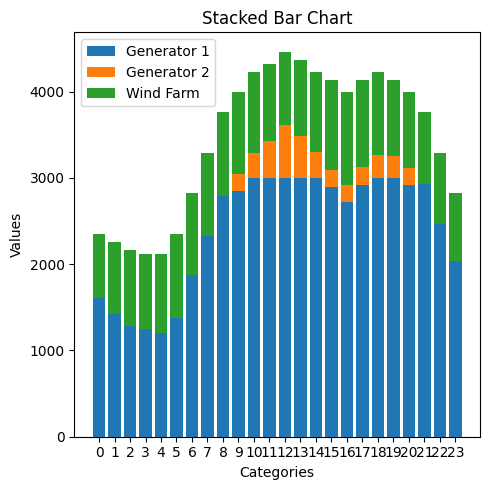

In [201]:
plot_stacked_bar_chart(df_final_dispatch)

if we would preventively run generator 2 all the time

In [208]:
excessive_consumption = (df_final_dispatch["Generator 2"] == 0).sum() * df_generators.loc[1, "min_output"] * \
                        df_generators.loc[1, "fuel_liter_per_kW_output"]
excessive_consumption

648.0

In [210]:
df_generators.loc[:, "fuel_liter_per_kW_output"].values

array([0.24, 0.27])

In [215]:
total_consumption = df_generators.loc[:, "fuel_liter_per_kW_output"].values.dot(
    df_final_dispatch[["Generator 1", "Generator 2"]].values.T).sum()

In [217]:
total_consumption

14872.232964477538

In [218]:
excessive_consumption / total_consumption

0.043571130276654074

Additional savings potential:
- Optimization of startup costs
- Optimization of the dispatch with non-linear starting curves
- Higher optimization potential with more components in the microgrid, especially energy storage